This is based off of this Project:

1) provides the forward model of the imaging process.  Namely given a numerical phantom (“image”) of say the head), takes user provided field maps for the B0 magnet, and the gradients and RF coil and generates what the kspace of that object is expected to be.
2) Show the conventional FFT reconstruction of this modeled data and compare it to the ground truth object with some set of metrics (of distortion etc.)
3) Do an iterative reconstruction of the ground-truth object using the forward model to give a "best case” look at how this configuration of fields would image.  Note that if the fields render an ill-posed inverse problem, there will be residual aliasing and noise amplification.  Provide metrics of these.

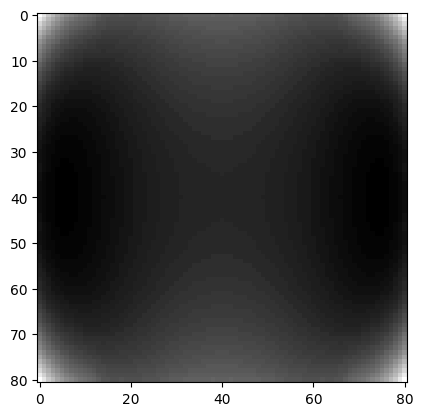

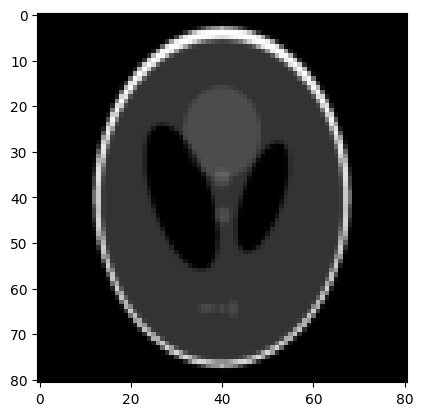

In [25]:
import numpy as np
from scipy.fft import fftshift, fft2
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import resize
import pandas as pd


# Re-generate and resize Shepp-Logan phantom
phantom = shepp_logan_phantom()
phantom = resize(phantom, (81, 81))
phantom /= np.max(phantom)

# Load the B0 field map from the csv file
B0_field_map = pd.read_csv('2Dslice.csv', header=None).values

# Plot the B0 field map
plt.imshow(np.abs(B0_field_map), cmap='gray')
plt.show()

# Plot the phantom
plt.imshow(np.abs(phantom), cmap='gray')
plt.show()


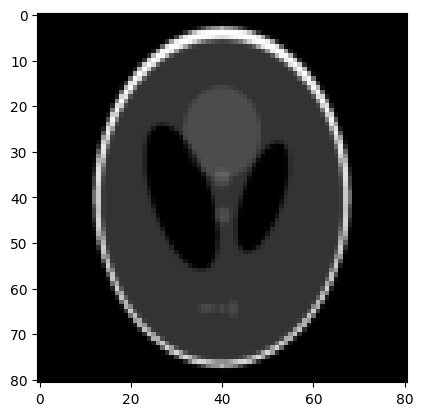

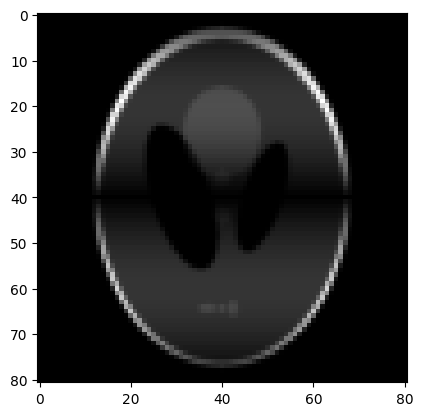

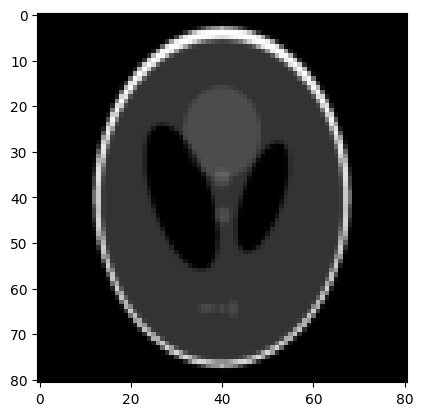

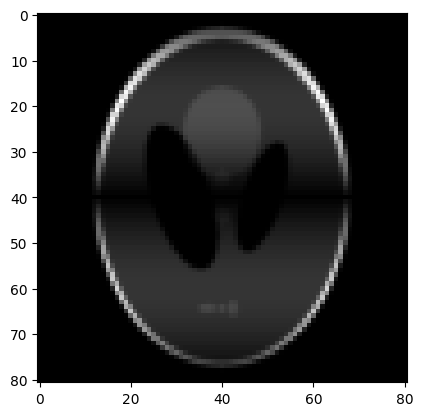

In [26]:
# Define the T2 relaxation time, echo time and time step
T2 = 0.1  # in seconds
TE = 0.1  # in seconds
dt = 1e-6  # in seconds
n_steps = int(TE / dt)

# Initialize k-space array
k_space = np.zeros((81, 81), dtype=complex)

# Number of phase encoding steps
n_pe = 81

# Phase encoding gradient values
Gy_values = np.linspace(-1, 1, n_pe)
Gx = 1

# For each phase encoding step
for i, Gy in enumerate(Gy_values):
    # Initialize the magnetization and apply the 90-degree RF pulse
    Mx = np.zeros((81, 81))
    My = np.zeros((81, 81))
    Mz = phantom
    # Apply 90-degree RF pulse
    new_Mz = Mz * np.cos(np.pi / 2) - My * np.sin(np.pi / 2)
    new_My = Mz * np.sin(np.pi / 2) + My * np.cos(np.pi / 2)
    My = new_My
    Mz = new_Mz

    # Apply the phase encoding gradient
    phase_shift_y = Gy * np.linspace(-np.pi, np.pi, 81)
    Mx *= np.cos(phase_shift_y)[:, None]
    My *= np.sin(phase_shift_y)[:, None]

    # Apply the B0 field map
    # phase_shift_B0 = 2 * np.pi * B0_field_map * TE
    # Mx *= np.cos(phase_shift_B0)
    # My *= np.sin(phase_shift_B0)

    # Simulate free precession and T2 decay until TE
    for _ in range(n_steps):
        Mz = Mz * np.exp(-dt / T2)
    
    # Plot Mz
    plt.imshow(np.abs(Mz), cmap='gray')
    plt.show()

    # Apply the 180-degree pulse
    new_Mz = Mz * np.cos(np.pi) - My * np.sin(np.pi)
    new_My = Mz * np.sin(np.pi) + My * np.cos(np.pi)
    My = new_My
    Mz = new_Mz


    # Generate the MR signal
    signal = np.sqrt(Mx**2 + My**2)
    signal = signal.astype(complex)  # Convert signal to complex

    # Apply the frequency encoding gradient
    phase_shift_x = Gx * np.linspace(-np.pi, np.pi, 81)
    signal *= np.exp(1j * phase_shift_x)[None, :]

    # Plot the signal
    plt.imshow(np.abs(signal), cmap='gray')
    plt.show()

    # Fourier transform the signal along the x-direction to get the k-space line
    k_space_line = np.abs(np.fft.fft(signal, axis=1))

    # Assign the k-space line to the corresponding row in the k-space
    k_space[i, :] = k_space_line[i, :]


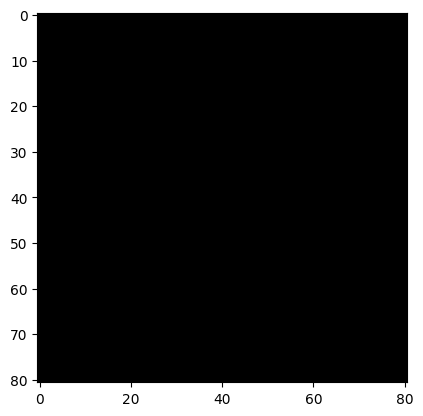

In [27]:
# Plot the k-space
plt.imshow(np.abs(k_space), cmap='gray')
plt.show()

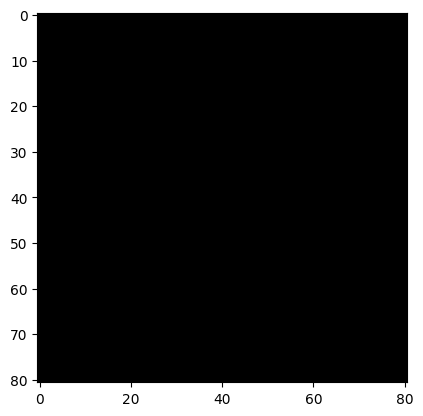

In [28]:
# Take the inverse Fourier transform and reconstruct the image
reconstructed_image = np.fft.ifft2(np.fft.ifftshift(k_space))
plt.imshow(np.abs(reconstructed_image), cmap='gray')
plt.show()